<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/Partial_Convolutions_Tr4_NMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!git clone https://github.com/MehakArora/ImageInpainting.git
%cd ImageInpainting

Cloning into 'ImageInpainting'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.
/content/ImageInpainting/ImageInpainting


In [44]:
!pip install tensorflow-gpu==2.0

In [45]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.client import device_lib
#from pconv_layer import PConv2D

from utils.pconv_layer import PConv2D

import cv2
print(cv2.__version__)
from skimage.metrics import structural_similarity as SSIM
from mpl_toolkits.axes_grid1 import ImageGrid

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.8.0
4.1.2
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [46]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [47]:
## Cifar 10 Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


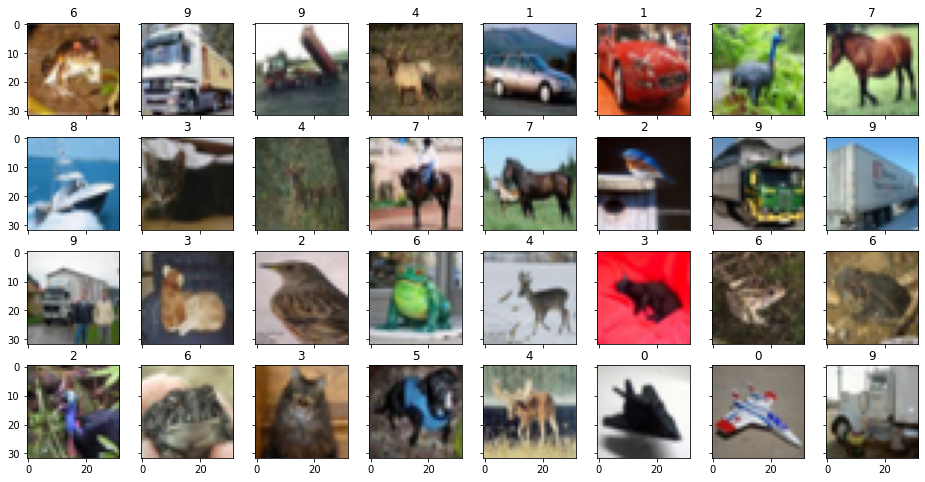

In [48]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

In [49]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [50]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

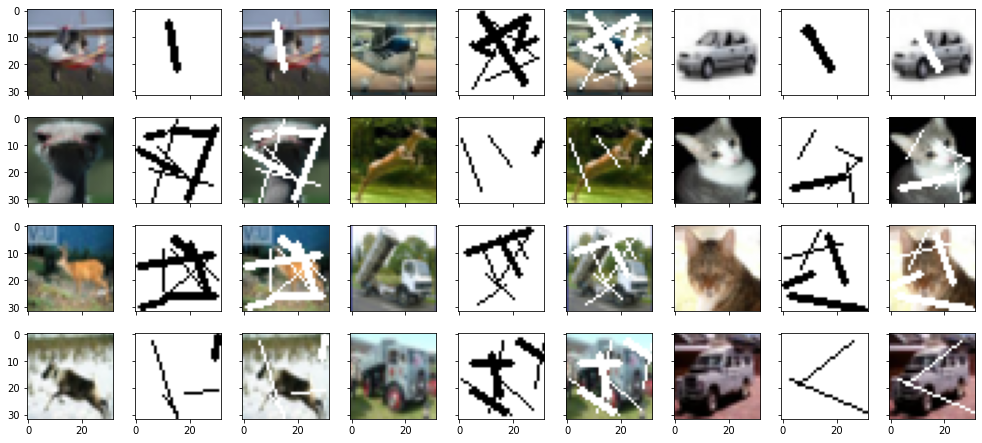

In [51]:
# Legend: Original Image | Mask generated | Masked Image

## Examples
sample_idx = 90 ## Change this to see different batches

[masked_images, masks], sample_labels = traingen[sample_idx]
sample_images = [None]*(len(masked_images)+len(masks)+len(sample_labels))
sample_images[::3] = sample_labels
# masks[]
sample_images[1::3] = masks
sample_images[2::3] = masked_images

fig = plt.figure(figsize=(17., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 9),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

# Partial Convolutions


For tasks like image segmentation, image inpainting etc, pixel-wise accuracy is not a good metric because of high color class imbalance. Though it’s easy to interpret, the accuracy score is often misleading. Two commonly used alternatives are IoU (Intersection over Union) and Dice Coefficient. They are both similar, in the sense that the goal is to maximize the area of overlap between the predicted pixel and the ground truth pixel divided by their union.

In [52]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [53]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(32,32,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

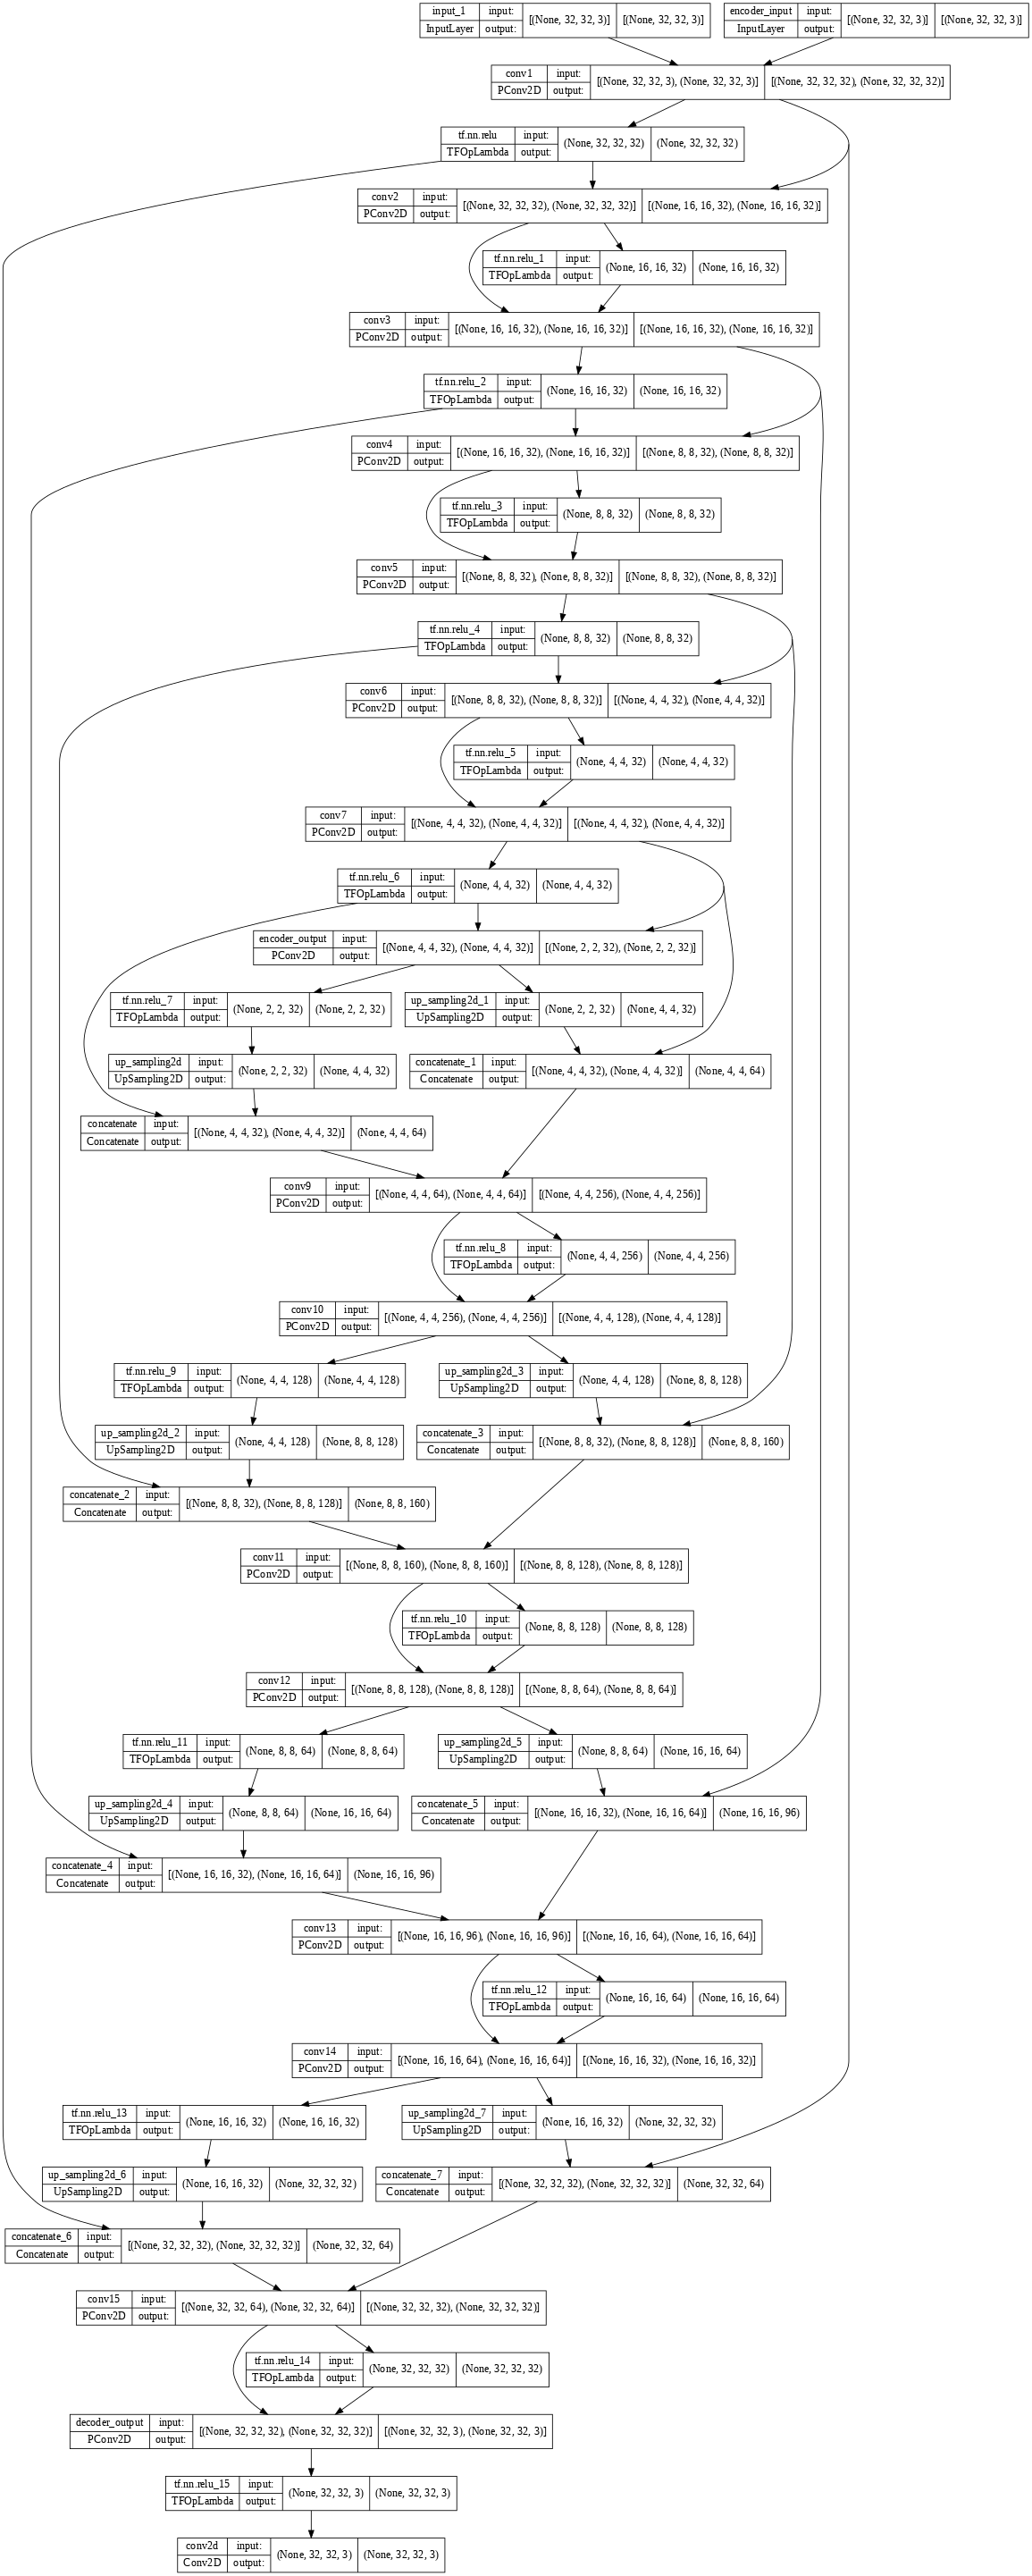

In [54]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
# model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=60, to_file='model_v2.png')

In [55]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

        #wandb.log({"masked_images": [wandb.Image(m_image)
         #                     for m_image in m_images]})
        #wandb.log({"masks": [wandb.Image(mask)
         #                     for mask in binary_masks]})
        #wandb.log({"predictions": [wandb.Image(inpainted_image)
         #                     for inpainted_image in predictions]})
        #wandb.log({"labels": [wandb.Image(label)
         #                     for label in labels]})

In [56]:
_ = model.fit_generator(traingen, validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,
          callbacks=[PredictionLogger()])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


1562/1562 [==============================] - 60s 36ms/step - loss: 0.0911 - dice_coef: 0.5721 - val_loss: 0.0701 - val_dice_coef: 0.5880
Epoch 2/20
1562/1562 [==============================] - 56s 36ms/step - loss: 0.0565 - dice_coef: 0.5917 - val_loss: 0.0406 - val_dice_coef: 0.5996
Epoch 3/20
1562/1562 [==============================] - 55s 35ms/step - loss: 0.0382 - dice_coef: 0.5980 - val_loss: 0.0364 - val_dice_coef: 0.6007
Epoch 4/20
1562/1562 [==============================] - 56s 35ms/step - loss: 0.0356 - dice_coef: 0.5986 - val_loss: 0.0346 - val_dice_coef: 0.6022
Epoch 5/20
1562/1562 [==============================] - 56s 36ms/step - loss: 0.0339 - dice_coef: 0.5989 - val_loss: 0.0331 - val_dice_coef: 0.6009
Epoch 6/20
1562/1562 [==============================] - 56s 36ms/step - loss: 0.0325 - dice_coef: 0.5994 - val_loss: 0.0319 - val_dice_coef: 0.6005
Epoch 7/20
1562/1562 [==============================] - 56s 36ms/step - loss: 0.0315 - dice_coef: 0.5997 - val_loss: 0.0309

Image (1): PSNR = 361.201999, SSIM = 1.000000
Image (2): PSNR = 361.201999, SSIM = 1.000000
Image (3): PSNR = 361.201999, SSIM = 1.000000
Image (4): PSNR = 361.201999, SSIM = 1.000000
Image (5): PSNR = 361.201999, SSIM = 1.000000
Image (6): PSNR = 361.201999, SSIM = 1.000000
Image (7): PSNR = 361.201999, SSIM = 1.000000
Image (8): PSNR = 361.201999, SSIM = 1.000000
Image (9): PSNR = 361.201999, SSIM = 1.000000
Image (10): PSNR = 73.462591, SSIM = 0.999822
Image (11): PSNR = 361.201999, SSIM = 1.000000
Image (12): PSNR = 78.233803, SSIM = 0.999960
Image (13): PSNR = 361.201999, SSIM = 1.000000
Image (14): PSNR = 361.201999, SSIM = 1.000000
Image (15): PSNR = 361.201999, SSIM = 1.000000
Image (16): PSNR = 361.201999, SSIM = 1.000000
Image (17): PSNR = 78.233803, SSIM = 0.999953
Image (18): PSNR = 361.201999, SSIM = 1.000000
Image (19): PSNR = 361.201999, SSIM = 1.000000
Image (20): PSNR = 361.201999, SSIM = 1.000000
Image (21): PSNR = 361.201999, SSIM = 1.000000
Image (22): PSNR = 361.20

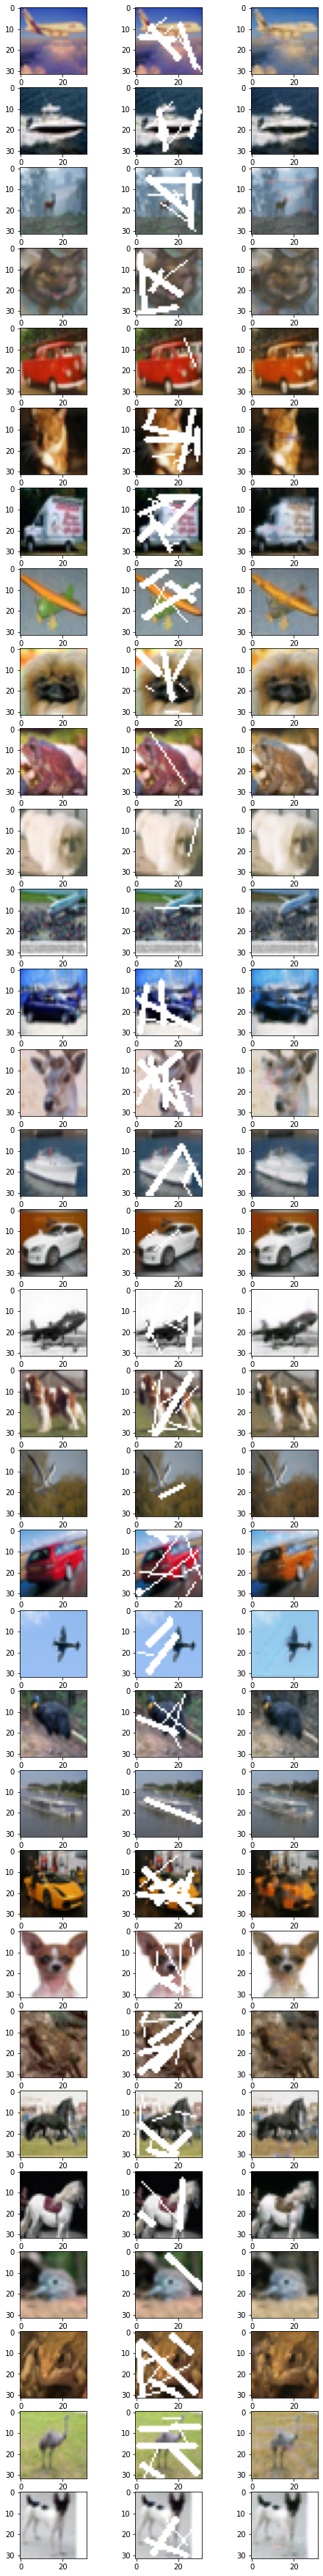

In [57]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth
from skimage.metrics import structural_similarity as SSIM
## Examples
rows = 32
sample_idx = 54
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)
  img_orig_gray = cv2.cvtColor(sample_labels[i].astype('uint8'),cv2.COLOR_BGR2GRAY)
  img_inpainted_gray = cv2.cvtColor(impainted_image.reshape(impainted_image.shape[1:]).astype('uint8'),cv2.COLOR_BGR2GRAY)
  PSNR_val = cv2.PSNR(img_orig_gray, img_inpainted_gray, 255)
  #print(PSNR)
  #SSIM_val = SSIM(sample_labels[i], impainted_image.reshape(impainted_image.shape[1:]),multichannel=True)
  SSIM_val = SSIM(img_orig_gray, img_inpainted_gray,multichannel=True)
  
  print("Image (%i): PSNR = %f, SSIM = %f"%(i+1,PSNR_val,SSIM_val))

  # Plotting:
  axs[i][0].imshow(sample_labels[i])                                              # Ground truth
  axs[i][1].imshow(masked_images[i])                                              # Masked image
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  #axs[i][0].set_xlabel('PSNR : ' + str(PSNR_val) + '\nSSIM: ' + str(SSIM_val))
  
  #axs[i][0].imshow(masked_images[i])
  #axs[i][1].imshow(masks[i])
  #axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  ##print(impainted_image.shape[1:])
  #axs[i][3].imshow(sample_labels[i])
  ##print(sample_labels[i])
  
plt.show()
fig.savefig("test2.png",dpi=600)

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
model.save("./drive/MyDrive/GA_Tech/Sp_2022_ECE_6254/my_model_part_conv2")

INFO:tensorflow:Assets written to: ./drive/MyDrive/GA_Tech/Sp_2022_ECE_6254/my_model_part_conv2/assets
